In [36]:
%matplotlib inline
from datetime import datetime;now = datetime.now;t00 = now()
import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

from contrastive_vae.celeb_utils import get_celeb_vae
from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

print(now()-t00)

0:00:00.003905


In [2]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')
print(now())

Mounted at /content/drive
done, mounted
2020-11-09 09:52:32.104387


In [ ]:
cd /content/drive/My Drive/BC-MRI-AE/

In [3]:
# def load_MR_data(indir):
    
#     files = [file for file in os.listdir(indir) if '.npy' in file]; files.sort()
#     data = np.array([np.load(os.path.join(indir,file)) for file in files])
#     print(data.shape)
#     return data

In [7]:
# t0 = now();print(f"started {t0}")

# #SFARI_data = load_MR_data('./Data/SFARI-64iso-normed/')
# ABIDE_data = load_MR_data('./Data/ABIDE-64iso-normed/')

# print(ABIDE_data.shape)
# print(f"finished in {now()-t0}")

started 2020-11-09 23:12:09.641945
(1060, 64, 64, 64)
(1060, 64, 64, 64)
finished in 0:00:06.299125


In [132]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

In [138]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

(982, 28, 28, 3)


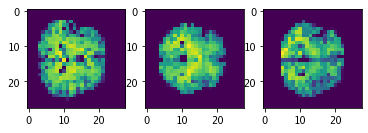

In [143]:
# BUILD DATA
import cv2 

nsubs = ABIDE_data.shape[0]
mid_idx = np.array([ABIDE_data[s,:,:,:].sum(axis=0).sum(axis=0).argmax() for s in range(nsubs)])
ABIDE_data_temp = np.array([ABIDE_data[s,:,:,mid_idx[s]-1:mid_idx[s]+2] for s in range(nsubs)])

targSize = (28,28)

ABIDE_data_3d = np.zeros((ABIDE_data_temp.shape[0],targSize[0],targSize[1],ABIDE_data_temp.shape[-1]))

for s in range(ABIDE_data_3d.shape[0]):
    for c in range(ABIDE_data_3d.shape[-1]):
        ABIDE_data_3d[s,:,:,c] = cv2.resize(ABIDE_data_temp[s,:,:,c],targSize)


print(ABIDE_data_3d.shape)

plt.subplot(1,3,1)
plt.imshow(ABIDE_data_3d[0,:,:,0])

plt.subplot(1,3,2)
plt.imshow(ABIDE_data_3d[60,:,:,0])

plt.subplot(1,3,3)
plt.imshow(ABIDE_data_3d[150,:,:,0])

982

100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


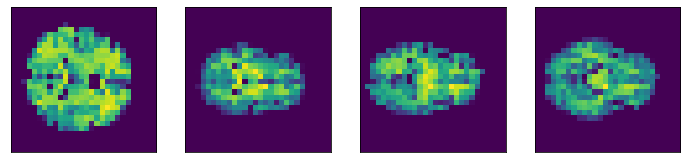

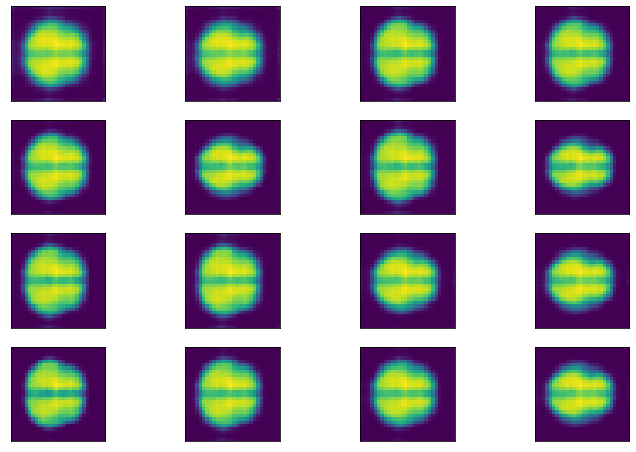

In [145]:
height = 28;width = 28;nchannels = 3;latent_dim = 2;batch_size = 64 
i,j,k=20,20,30

encoder, decoder, vae = get_celeb_vae(input_shape=(height, width, nchannels), latent_dim=latent_dim, batch_size=batch_size, disentangle=False, gamma=1)

for i in tqdm(range(100)):
  #vae.train_on_batch(data_batch)
  vae.train_on_batch(ABIDE_data_3d[np.random.randint(0,nsubs,batch_size),:,:,:])

plt.figure(figsize=(12,8))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(ABIDE_data_3d[np.random.randint(1,high=nsubs),:,:,0])
    plt.xticks([]);plt.yticks([])

plt.figure(figsize=(12,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(decoder.predict(np.random.randn(1,latent_dim))[0,:,:,0])
    plt.xticks([]);plt.yticks([])


In [200]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=1)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,ID,SUB_TYPE,VISIT,DAY_LAG,ABIDE_01,ABIDE_02,ABIDE_03,ABIDE_04,...,ABIDE_64,ABIDE_65,ABIDE_66,ABIDE_67,ABIDE_68,ABIDE_69,ABIDE_70,ABIDE_71,ABIDE_72,ABIDE_73
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [202]:
TD_subs = ABIDE_data_3d[np.array(df['SUB_TYPE']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data_3d[np.array(df['SUB_TYPE']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 28, 28, 3)
(456, 28, 28, 3)


In [203]:
dxArr = np.ones(len(df))
dxArr[np.array(df['SUB_TYPE']=='PATIENT')]=2

In [ ]:
height = 28;width = 28;nchannels = 3;latent_dim = 2;batch_size = 64 ;latent_dim_s = 4
i,j,k=20,20,30

cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_celeb_cvae(input_shape=(width, height, 3), latent_dim=latent_dim, bias=True, disentangle=True, gamma=1)

for i in tqdm(range(1000)):
#cvae.train_on_batch([tg_images, bg_images])
  cvae.train_on_batch([DX_subs[np.random.randint(0,DX_subs.shape[0],batch_size),:,:,:],TD_subs[np.random.randint(0,TD_subs.shape[0],batch_size),:,:,:]])

 96%|█████████▌| 962/1000 [00:54<00:02, 17.97it/s]

In [ ]:
plt.figure(figsize=(12,8))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(ABIDE_data_3d[np.random.randint(1,high=1060),:,:,0])
  plt.xticks([]);plt.yticks([])

plt.figure(figsize=(12,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(cvae_decoder.predict(np.random.randn(1,4))[0,:,:,0])
  plt.xticks([]);plt.yticks([])

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
z_mean, z_log_var, z = z_encoder(ABIDE_data_3d[:,:,:,:])
x = z
plt.scatter(x[:,0],x[:,1],c=dxArr)
plt.title('background')

plt.subplot(1,3,2)
s_mean, s_log_var, s = s_encoder(ABIDE_data_3d[:,:,:,:])
x = s
plt.scatter(x[:,0],x[:,1],c=dxArr)
plt.title('salient')

plt.subplot(1,3,3)
v_mean, v_log_var, v = encoder(ABIDE_data_3d[:,:,:,:])
x = v
plt.scatter(x[:,0],x[:,1],c=dxArr)
plt.title('v')

plt.figure(figsize=(6,4))
plt.bar([0,1,2],[silhouette_score(z,dxArr),silhouette_score(s,dxArr),silhouette_score(v,dxArr)])
plt.xticks([0,1,2],labels=['background','salient','vae'])

In [ ]:
plt.figure(figsize=(6,4))
arr = (z_log_var,s_log_var,v_log_var)
#arr = (z_mean,s_mean,v_mean)
arr = (z,s,v)
plt.bar([0,1,2],[silhouette_score(arr[0],dxArr),silhouette_score(arr[1],dxArr),silhouette_score(arr[2],dxArr)])
plt.xticks([0,1,2],labels=['background','salient','vae'])